### Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
import lightgbm as lightgbmclassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from tqdm import tqdm_notebook as tqdm
import scipy.ndimage
import tensorflow as tf
from sklearn import linear_model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv1D, BatchNormalization, AveragePooling1D, Reshape
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
!{sys.executable} -m pip install scikit-optimize

     |████████████████████████████████| 100 kB 2.4 MB/s 


In [ ]:
from skopt import BayesSearchCV

In [ ]:
RAND_STATE = 47
np.random.seed(RAND_STATE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get Updated clean and split files

In [ ]:
def get_train_test(tr = 'X_train.csv', te = 'X_test_all.csv'):
    # Returns a sample of original dataset
    # of 100k records of class 0 and all records of class 1
    # along with val and test datasets
    df = pd.read_csv(folder + tr)
    # test_df = pd.read_csv(folder + 'X_test.csv')
    test_all_df = pd.read_csv(folder + te)
    # Splitting for train and val
    X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, 3:],
                                                    df.target,
                                                    test_size=0.2, 
                                                    random_state=RAND_STATE,
                                                    stratify = df['target'])
    X_test_all = test_all_df.iloc[:, 3:]
    
    class_dict = {0 : 100000,
                  1 :  y_train.value_counts()[1]}
    
    rus = RandomUnderSampler(sampling_strategy = class_dict,
                             random_state = RAND_STATE) 
    X_res, y_res = rus.fit_resample(X_train, y_train)
    X_res.to_csv(folder+'charan/X_res.csv')
    y_res.to_csv(folder+'charan/y_res.csv')
    
    del df, test_all_df
#   return X_train, X_val, y_train, y_val, X_test_all
    return X_res, X_val, y_res, y_val, X_test_all

### Model Training

In [ ]:
def return_cv(folds = 5):
    inner_cv = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE)
    outer_cv = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE)
    return inner_cv, outer_cv

In [ ]:
inner_cv, outer_cv = return_cv(folds = 5)

In [ ]:
# Decision Tree
tree_para = {'max_depth': [3,5,9,12,15],
             'min_samples_split': [10,12,15],
             'max_features':['auto','sqrt'],
              'class_weight':['balanced'],
              'random_state': [47]}


dt_clf = BayesSearchCV(DecisionTreeClassifier(), tree_para,scoring = 'roc_auc', cv= inner_cv, n_iter = 10, n_jobs = 5,verbose = 2)
#score = cross_val_score(dt_clf, X=X_train,y=y_train,cv = outer_cv)
dt_clf.fit(X_train, y_train) 

print('Best Parameters:',dt_clf.best_params_)
print('Roc_auc:', dt_clf.cv_results_)
#print("%0.3f accuracy with a standard deviation of %0.3f" % (score.mean(), score.std()),"\n")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: OrderedDict([('max_depth', 9), ('max_features', 'auto'), ('min_samples_split', 12), ('random_state', 47)])
Roc_auc: {'mean_fit_time': array([33.32406707, 10.67920513, 14.62111249,  5.19536414, 12.10835238,
       13.94047146,  9.57825098, 11.81134667,  6.52759118, 11.69237785]), 'std_fit_time': array([2.33019214, 0.59130689, 0.21963626, 0.04976947, 0.1475645 ,
       0.20847272, 0.19857924,

In [ ]:
print('AUC values over 10 iterations of BayesSearchCV are:\n',dt_clf.cv_results_['mean_test_score'])

AUC values over 10 iterations of BayesSearchCV are:
 [0.57715872 0.60857246 0.61113716 0.57715872 0.62350464 0.61113716
 0.63155793 0.62438388 0.60857246 0.62680745]


No handles with labels found to put in legend.


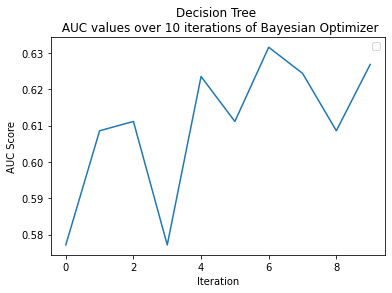

In [ ]:
plt.plot(dt_clf.cv_results_['mean_test_score'])
plt.legend()
plt.title('Decision Tree \n AUC values over 10 iterations of Bayesian Optimizer')
plt.xlabel('Iteration')
plt.ylabel('AUC Score')
plt.show()

In [ ]:
# inputs model, X_val and y_val to plot RoC curve
def plot_roc(model, X_val, y_val):
    # calculate the fpr and tpr for 
    # all thresholds of the classification
    preds = model.predict_proba(X_val)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot
    plt.title('Receiver Operating Characteristic - Stacked Ensemble Model')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

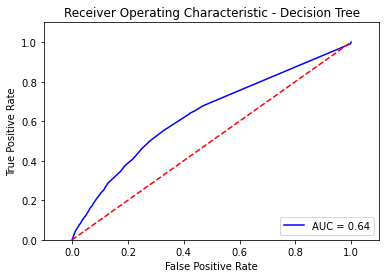

In [ ]:
plot_roc(dt_clf, X_val, y_val)

In [ ]:
# Random Forest

tree_para = {'max_depth': [9,12,15,20],
             'min_samples_split': [10,12,15,22],
             'bootstrap' : [True, False],
             'max_features':['auto','sqrt'],
              'class_weight':['balanced'],
              'random_state': [47]}


dt_rf = BayesSearchCV(RandomForestClassifier(), tree_para, scoring = 'roc_auc' , cv = inner_cv, n_iter = 10, n_jobs = 4,verbose = 2)
# score = cross_val_score(dt_rf, X=X_train,y=y_train,cv = outer_cv)
dt_rf.fit(X_train, y_train)

print('Best Parameters:',dt_rf.best_params_)
print('Roc_auc:', dt_rf.cv_results_)

# print("%0.3f negative mean squared error with standard deviation of %0.3f" % (score.mean(), score.std()),"\n")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 15), ('max_features', 'auto'), ('min_samples_split', 15), ('random_state', 47)])
Roc_auc: {'mean_fit_time': array([ 476.78930845, 1120.09519196,  683.52198715,  472.86243525,
        741.48304124,  558.68730497,  311.80640235,  574.66329093,
        358.12575474,  225.24097719]), 'std_fit_time': array([ 13.08970021,  30.15453223,  14.81342833,

In [ ]:
print('AUC values over 10 iterations of BayesSearchCV are:\n',dt_rf.cv_results_['mean_test_score'])

AUC values over 10 iterations of BayesSearchCV are:
 [0.80823425 0.81574569 0.80578702 0.80995941 0.81617988 0.81535472
 0.81099265 0.81574569 0.81617988 0.80995941]


No handles with labels found to put in legend.


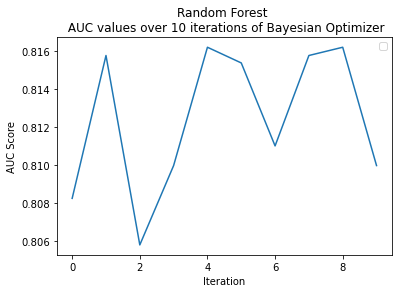

In [ ]:
plt.plot(dt_rf.cv_results_['mean_test_score'])
plt.legend()
plt.title('Random Forest \n AUC values over 10 iterations of Bayesian Optimizer')
plt.xlabel('Iteration')
plt.ylabel('AUC Score')
plt.show()

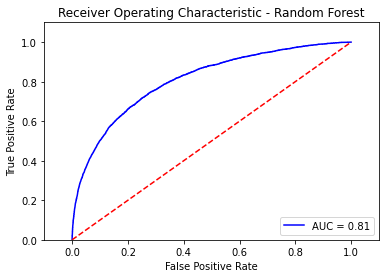

In [ ]:
plot_roc(dt_rf, X_val, y_val)